In [1]:
import os
import xarray as xr
import pandas as pd
os.environ["PROJ_LIB"] = "C:/Users/Holdenje/Documents/R/win-library/3.5/sf/proj/"
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

#some pd parameters
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'left')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import Image
%matplotlib inline


In [2]:
pathname = "C:/Users/Holdenje/DRIFT/sample_drift-tool_output/individual-sets/SalishSea-hourly_output/"
drifterid = "P2D-wp4372522492D20160617"
filename = drifterid + "_aggregated.nc"
#savedir = "C:/Users/Holdenje/DRIFT/plots/output_plotting-cleanup/aggregated_plots/new_format/20200513/SalishSea-hourly_output/QC_plots/indv/"
savedir = "C:/Users/Holdenje/PycharmProjects/drift-analysis/jen/jupyter_notebooks/notebook_output/examine_aggregated_netcdfs_output/"

In [3]:
file = os.path.join(pathname, filename)
with xr.open_dataset(file) as ds:
    print(file)

C:/Users/Holdenje/DRIFT/sample_drift-tool_output/individual-sets/SalishSea-hourly_output/P2D-wp4372522492D20160617_aggregated.nc


In [4]:
make_plots = False
if make_plots:

    def bin_skills(ds, skill, duration, sampling_freq):
        """ bin skill scores by drifter """
        ds['time_since_start'] = ds['time'].astype(np.timedelta64)
        for m in ds.model_run.values:
            ds['time_since_start'][m, :] = ds['time'][m, :] - ds['mod_start_date'][m].astype(str).astype(np.datetime64) 
        df = ds.to_dataframe()
        df = df.set_index('time_since_start')
        df_res = df[skill].dropna().sort_index().resample(sampling_freq, closed='right', label='right').mean().interpolate()
        df_res = df_res.reset_index()
        df_res['hours since start'] = df_res.time_since_start.astype('timedelta64[h]')
        return df_res

    df_res = bin_skills(ds, 'sep', '48', '1H')
    sep_max = np.nanmax(df_res['sep'].values)
    df_all = ds.to_dataframe()
    startdates = ds.mod_start_date.values
    max_sep = np.nanmax(df_all['sep'])
    max_molcard = np.nanmax(df_all['molcard'])

    print('there are ',np.nanmax(ds.model_run.values), 'runs')
    for m in ds.model_run.values:
        plt.close()
        print('plotting' + drifterid + '_run' + str(m))

        # get the binned versions of sep and molcard
        df_use = df_all[df_all.index.get_level_values('model_run') == m].copy()   

        def bin_run_skills(df_use, skill):
            import dateutil
            df_use['startdate'] = dateutil.parser.parse(startdates[m])
            df_use['time_since_start'] = df_use['time'].values - df_use['startdate']
            df_use = df_use.set_index('time_since_start')
            df_use = df_use[skill].dropna().sort_index().resample('1H', closed='right', label='right').mean().interpolate()
            df_use = df_use.reset_index()
            df_use['hours since start'] = df_use.time_since_start.astype('timedelta64[h]')
            return df_use

        df_sep = bin_run_skills(df_use, 'sep')
        df_mol = bin_run_skills(df_use, 'molcard')

        # make the plot
        fig, ax = plt.subplots(3, 2, squeeze=False, figsize=(11, 8.5))

        #sep plot
        ax[0][0].plot(ds.time[m,:].values, ds.sep[m,:].values,'b.')
        ax[0][0].minorticks_on()
        ax[0][0].grid(which='major', alpha=0.4)
        ax[0][0].set_title('non-binned sep')
        ax[0][0].set_ylim([0, max_sep])

        #molcard
        ax[0][1].plot(ds.time[m,:].values, ds.molcard[m,:].values,'b.')
        ax[0][1].minorticks_on()
        ax[0][1].grid(which='major', alpha=0.4)
        ax[0][1].set_title('non-binned molcard')
        ax[0][1].set_ylim([0, 1])

        ax[2][0].plot(df_res['hours since start'], df_res['sep'],'b.')
        ax[2][0].set_title('average sep for all runs')
        ax[2][0].grid(which='major', alpha=0.4)
        ax[2][0].set_ylim([0,max_sep])
        ax[2][0].axvline(x=48,linewidth=0.5)
        ax[2][0].grid(which='minor', alpha=0.2)

        exlats = []
        exlons = []
        #the map
        exlats.append(ds.obs_lat[m,:].values) 
        exlats.append(ds.mod_lat[m,:].values)
        exlons.append(ds.obs_lon[m,:].values) 
        exlons.append(ds.mod_lon[m,:].values)

        map = Basemap(projection='merc', 
                      llcrnrlon=np.nanmin(exlons)-0.05, urcrnrlon=np.nanmax(exlons)+0.05, 
                      llcrnrlat=np.nanmin(exlats)-0.05, urcrnrlat=np.nanmax(exlats)+0.05, 
                      resolution='f', ax=ax[2][1])

        x,y = map(ds.obs_lon[m,:].values, ds.obs_lat[m,:].values)
        mx,my = map(ds.mod_lon[m,:].values, ds.mod_lat[m,:].values)
        map.plot(x, y, 'k.', zorder = 10, markersize=2)
        map.plot(mx, my, 'b.', zorder = 1, markersize=2)
        map.drawcoastlines()
        map.fillcontinents()

        #binned sep plot
        ax[1][0].plot(df_sep['hours since start'], df_sep['sep'],'b.')
        ax[1][0].minorticks_on()
        ax[1][0].grid(which='major', alpha=0.4)
        ax[1][0].set_title('binned sep')
        ax[1][0].set_ylim([0, max_sep])
        ax[1][0].set_xlim([0, 50])
        ax[1][0].axvline(x=48,linewidth=0.5)

        #binned molcard plot
        ax[1][1].plot(df_mol['hours since start'], df_mol['molcard'],'b.')
        ax[1][1].minorticks_on()
        ax[1][1].grid(which='major', alpha=0.4)
        ax[1][1].set_title('binned molcard')
        ax[1][1].set_ylim([0, 1])
        ax[1][1].set_xlim([0, 50])
        ax[1][1].axvline(x=48,linewidth=0.5)

        fig.suptitle(str(drifterid) + ' (run number ' + str(m) + ')')
        filename = drifterid + '_run' + str(m) + '.png'
        plt.savefig(os.path.join(savedir,filename),bbox_inches='tight',
                    dpi=300,papertype='letter',orientation='portrait')
        plt.close()

    print('done')

    


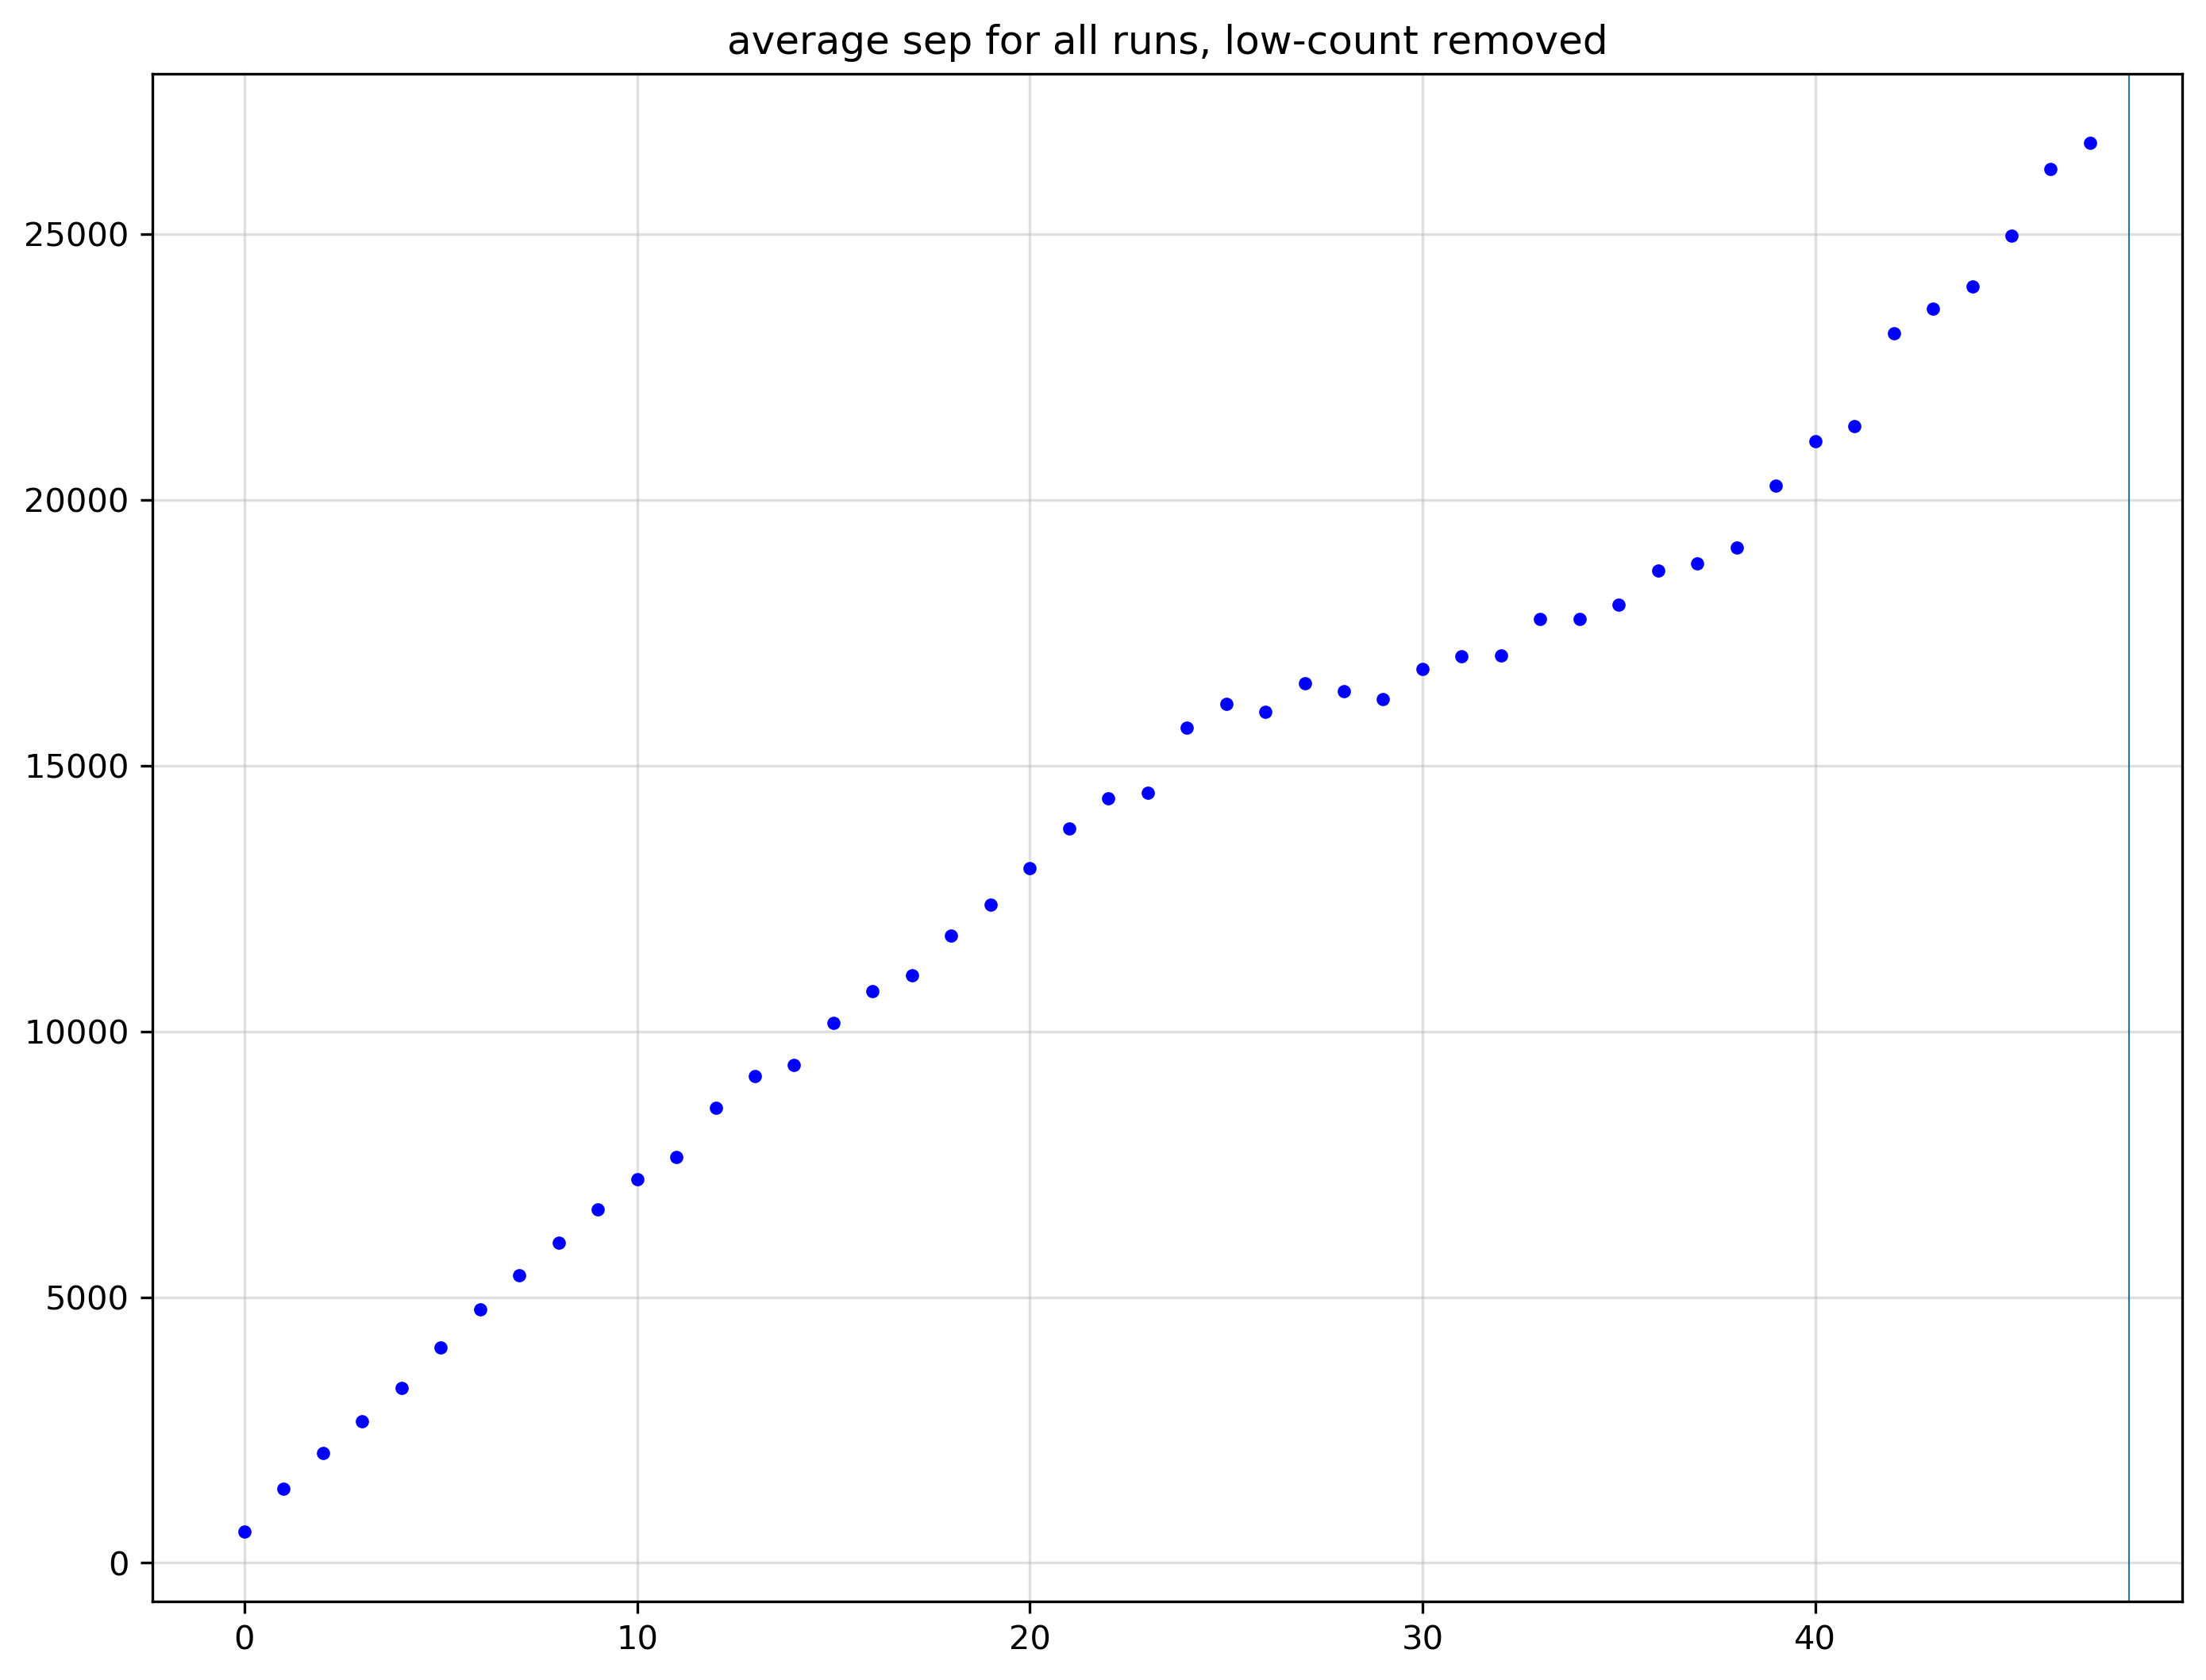

<function __main__.show_images(file)>

In [5]:
directory='notebook_output/examine_aggregated_netcdfs_output/'
images = widgets.Dropdown(options=os.listdir(directory))

def show_images(file):
    display(Image(directory+file))

interact(show_images,file=images)

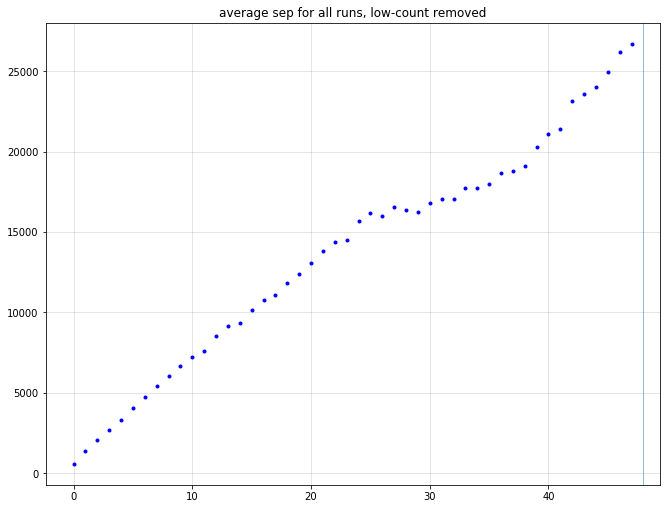

In [6]:
def bin_skills(ds, skill, duration, sampling_freq):
    """ bin skill scores by drifter """
    ds['time_since_start'] = ds['time'].astype(np.timedelta64)
    for m in ds.model_run.values:
        ds['time_since_start'][m, :] = ds['time'][m, :] - ds['mod_start_date'][m].astype(str).astype(np.datetime64) 
    df = ds.to_dataframe()
    df_hours = df.copy()
    df = df.set_index('time_since_start')
    df_res = df[skill].dropna().sort_index().resample(sampling_freq, closed='right', label='right').mean().interpolate()
    df_res = df_res.reset_index()
    df_res['hours since start'] = df_res.time_since_start.astype('timedelta64[h]')
    
    #to remove the bad end point
    df_hours['hours since start'] = df_hours.time_since_start.astype('timedelta64[h]')
    df_hours = df_hours[['hours since start', skill]]
    df_hours = df_hours.reset_index()
    df_hours = df_hours.drop(['timestep','model_run'], axis = 1)
    df_hours = df_hours.set_index('hours since start')
    skill_count = df_hours.groupby(['hours since start']).size().reset_index(name='counts')
    # if there is a median of at least 10 counts at the other times, don't plot times where 
    # there are less than 3 values (values chosen at random)
    if np.nanmedian(skill_count['counts'].values.tolist()) > 10:
        include_list = skill_count['hours since start'][skill_count['counts'] > 3].values.tolist()
        df_res = df_res[df_res['hours since start'].isin(include_list)]
    
    return df_res

df_res = bin_skills(ds, 'sep', '48', '1H')

# make the plot
fig, ax = plt.subplots(1, 1, squeeze=False, figsize=(11, 8.5))
ax[0][0].plot(df_res['hours since start'], df_res['sep'],'b.')
ax[0][0].set_title('average sep for all runs, low-count removed')
ax[0][0].grid(which='major', alpha=0.4)
ax[0][0].axvline(x=48,linewidth=0.5)
ax[0][0].grid(which='minor', alpha=0.2)
filename = drifterid + '_average_sep' + '.png'
plt.show()    


In [24]:
def bin_skills(ds, skill, duration, sampling_freq):
    """ bin skill scores by drifter """
    ds['time_since_start'] = ds['time'].astype(np.timedelta64)
    for m in ds.model_run.values:
        ds['time_since_start'][m, :] = ds['time'][m, :] - ds['mod_start_date'][m].astype(str).astype(np.datetime64) 
    df = ds.to_dataframe()
    
    #df = df[df.index.get_level_values('model_run') == 11]
    
    df_hours = df.copy()
    df['hours since start'] = df.time_since_start.astype('timedelta64[h]')
    print()
    print('\n', df[['time','hours since start','time_since_start','sep']][df['hours since start'] >= 47])
    df = df.set_index('time_since_start')
    df_res = df[skill].dropna().sort_index().resample(sampling_freq, closed='right', label='right').mean().interpolate()
    df_res = df_res.reset_index()
    #df_res['hours since start'] = df_res.time_since_start.astype('timedelta64[h]')
    
    #to remove the bad end point
    df_hours['hours since start'] = df_hours.time_since_start.astype('timedelta64[h]')
    df_hours = df_hours[['hours since start', skill]]
    df_hours = df_hours.reset_index()
    df_hours = df_hours.drop(['timestep','model_run'], axis = 1)
    df_hours = df_hours.set_index('hours since start')
    skill_count = df_hours.groupby(['hours since start']).size().reset_index(name='counts')
    # if there is a median of at least 10 counts at the other times, don't plot times where 
    # there are less than 3 values (values chosen at random)
    if np.nanmedian(skill_count['counts'].values.tolist()) > 10:
        include_list = skill_count['hours since start'][skill_count['counts'] > 3].values.tolist()
        #df_res = df_res[df_res['hours since start'].isin(include_list)]
    
    return df_res

df_res = bin_skills(ds, 'sep', '48', '1H')







                    time                 hours since start time_since_start  sep         
model_run timestep                                                                      
0         535      2016-06-19 11:01:30  47.0              1 days 23:01:30   14405.635349
          536      2016-06-19 11:05:52  47.0              1 days 23:05:52   14394.958911
          537      2016-06-19 11:10:54  47.0              1 days 23:10:54   14383.492094
          538      2016-06-19 11:15:53  47.0              1 days 23:15:53   14365.278822
          539      2016-06-19 11:20:53  47.0              1 days 23:20:53   14355.450225
          540      2016-06-19 11:25:50  47.0              1 days 23:25:50   14343.290443
          541      2016-06-19 11:30:50  47.0              1 days 23:30:50   14337.292941
          542      2016-06-19 11:35:48  47.0              1 days 23:35:48   14343.558687
          543      2016-06-19 11:40:48  47.0              1 days 23:40:48   14346.381089
          544     